<a href="https://colab.research.google.com/github/milindsahay/Neural_style_transfer/blob/master/Neural_style_transfer_compiled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install -q kaggle

In [0]:
! mkdir ~/.kaggle

In [0]:
! cp kaggle.json ~/.kaggle/

In [0]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle datasets download -d teksab/imagenetvggverydeep19mat

 99% 505M/510M [00:12<00:00, 44.4MB/s]
100% 510M/510M [00:12<00:00, 42.2MB/s]


In [13]:
!unzip imagenetvggverydeep19mat.zip

Archive:  imagenetvggverydeep19mat.zip
  inflating: imagenet-vgg-verydeep-19.mat  


In [1]:
!pip install tensorflow==1.15
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

     |████████████████████████████████| 412.3MB 40kB/s 
     |████████████████████████████████| 3.8MB 40.2MB/s 
     |████████████████████████████████| 512kB 32.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=67b262bd2ed4badbdde853246850819c2919b28579e8ae334b3ad50dad6bbabf
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installatio

In [14]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [15]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(model)

{   'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) 

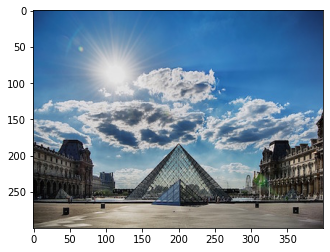

In [36]:
image = plt.imread('louvre.jpg')
plt.imshow(image)

In [0]:
content = reshape_and_normalize_image(image)

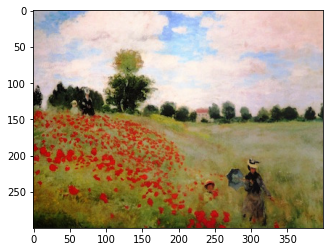

In [38]:
image = plt.imread('monet.jpg')
plt.imshow(image)

In [0]:
style = reshape_and_normalize_image(image)

In [0]:
def display_image(image):
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    image = image + MEANS
    image = np.clip(image[0], 0, 255).astype('uint8')
    plt.imshow(image)

In [0]:
def content_cost(gen_image, con_image):
    #input as tensors
    return (tf.reduce_sum(tf.square(gen_image-con_image)))

In [0]:
def gram_matrix(m):
    #input tensor of shape (n_w*n_h,n_c)
    return tf.matmul(tf.transpose(m),m)

In [0]:
def single_style_cost(gen_image, st_image):
    #input tensor of shape (m,n_w,n_h,n_c)
    
    gen_image = tf.squeeze(gen_image)
    st_image = tf.squeeze(st_image)
    
    #reshaping to (n_w*n_h,n_c)
    n_w, n_h, n_c = gen_image.get_shape().as_list()
    gen_r = tf.reshape(gen_image, shape=[n_w*n_h,n_c])
    st_r = tf.reshape(st_image, shape=[n_w*n_h,n_c])
    
    gram_gen = gram_matrix(gen_r)
    gram_st = gram_matrix(st_r)
    
    return tf.reduce_sum(tf.square(gram_st - gram_gen))

In [0]:
def style_cost(model, style_layer):
    
    cost = 0
    weights = float(1/len(style_layer))
    # iterating through each layer
    for layer in style_layer:
        output = model[layer]
        #activations of this layer
        st_im = sess.run(output)
        
        gen_im = output
        cost+= weights*single_style_cost(gen_im,st_im)
    return cost    

In [45]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
content_layer = ['conv5_3']
style_layer = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

In [0]:
generated_image = reshape_and_normalize_image(plt.imread('louvre.jpg'))
model = model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [0]:
sess.run(model["input"].assign(content))
out = model[content_layer[0]]
act_content = sess.run(out)
act_gen = out
con_cost = content_cost(act_gen,act_content)

In [0]:
sess.run(model["input"].assign(style))
sty_cost = style_cost(model,style_layer)

In [0]:
alpha = 10
beta = 40
total_cost = alpha*con_cost + beta*sty_cost

In [0]:
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(total_cost)

In [0]:
def model_nn(sess, input_image, num_iterations = 2000):

    sess.run(tf.global_variables_initializer())
    
    sess.run(model['input'].assign(input_image))
   
    for i in range(num_iterations):
    
        sess.run(train_step)
        
        generated_image = sess.run(model['input'])
        
        if i%100 == 0:
            t_c, c_c, s_c = sess.run([total_cost, con_cost, sty_cost])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(t_c))
            print("content cost = " + str(c_c))
            print("style cost = " + str(s_c))
            
            #display_image(generated_image)
            #save_image("output/" + str(i) + ".png", generated_image)
    
    #save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

Iteration 0 :
total cost = 1.8367089e+22
content cost = 805118.0
style cost = 4.5917724e+20
Iteration 100 :
total cost = 7.027715e+20
content cost = 5331044.5
style cost = 1.7569288e+19
Iteration 200 :
total cost = 2.4928012e+20
content cost = 5598543.0
style cost = 6.232003e+18
Iteration 300 :
total cost = 1.2009547e+20
content cost = 5689551.0
style cost = 3.0023866e+18
Iteration 400 :
total cost = 6.682259e+19
content cost = 5802904.0
style cost = 1.6705647e+18
Iteration 500 :
total cost = 4.7924528e+19
content cost = 5900642.0
style cost = 1.1981132e+18
Iteration 600 :
total cost = 3.6065556e+19
content cost = 5945006.0
style cost = 9.016389e+17
Iteration 700 :
total cost = 3.0903028e+19
content cost = 5998460.0
style cost = 7.725757e+17
Iteration 800 :
total cost = 2.7171197e+19
content cost = 6011485.5
style cost = 6.792799e+17
Iteration 900 :
total cost = 7.226752e+19
content cost = 5983230.0
style cost = 1.8066881e+18
Iteration 1000 :
total cost = 2.1820771e+19
content cost = 6

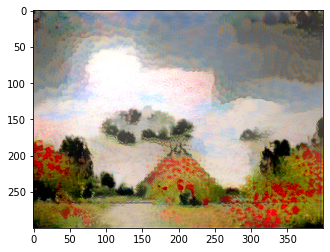

In [56]:
im = model_nn(sess, generated_image)
display_image(im)